In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/

In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 87% 105M/121M [00:02<00:00, 41.1MB/s] 
100% 121M/121M [00:02<00:00, 57.1MB/s]


In [ ]:
!unzip face-expression-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import glob

# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, transform=None, string="train"):
        self.imgs_path = "images/" + string + "/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = os.path.basename(class_path)
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        self.class_map = {"angry": 0, "disgust": 1, "fear": 2, "happy": 3, "neutral": 4, "sad": 5, "surprise": 6}
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = Image.open(img_path)
        class_id = self.class_map[class_name]
        if self.transform:
            img = self.transform(img)
        return img, class_id

# Define transforms for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize images
])

# Load train and validation datasets using MyDataset class
train_dataset = MyDataset(transform=transform, string="train")
val_dataset = MyDataset(transform=transform, string="validation")

# Create DataLoader for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class EmotionClassifier(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # Adjusted input size after flattening
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        #print("Input shape:", x.shape)
        x = torch.relu(self.conv1(x))
        #print("Shape after conv1:", x.shape)
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        #print("Shape after maxpool1:", x.shape)
        x = torch.relu(self.conv2(x))
        #print("Shape after conv2:", x.shape)
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        #print("Shape after maxpool2:", x.shape)
        x = torch.relu(self.conv3(x))
        #print("Shape after conv3:", x.shape)
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        #print("Shape after maxpool3:", x.shape)
        x = x.view(x.size(0), -1)
        #print("Shape after flattening:", x.shape)
        x = torch.relu(self.fc1(x))
        #print("Shape after fc1:", x.shape)
        x = self.fc2(x)
        #print("Shape after fc2:", x.shape)
        return x

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

# Evaluation on validation set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {(correct / total) * 100:.2f}%")


Epoch [1/10], Loss: 1.575979580889796
Epoch [2/10], Loss: 1.336216304529785
Epoch [3/10], Loss: 1.218259644428977
Epoch [4/10], Loss: 1.1345005415123655
Epoch [5/10], Loss: 1.0557881573196521
Epoch [6/10], Loss: 0.976792973928261
Epoch [7/10], Loss: 0.8911521533022445
Epoch [8/10], Loss: 0.8012668655794548
Epoch [9/10], Loss: 0.7054628868412628
Epoch [10/10], Loss: 0.6064528870695042
Validation Accuracy: 56.13%


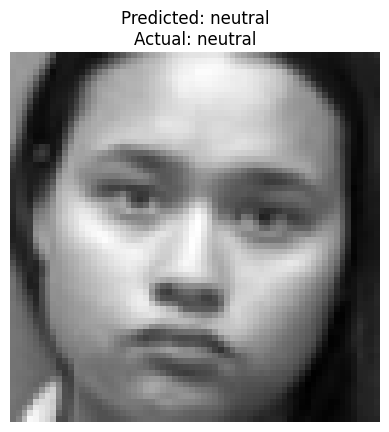

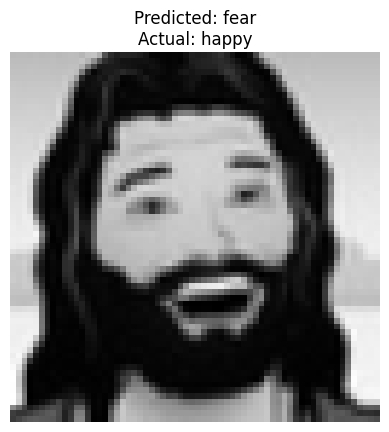

In [ ]:
import random
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Take 5 random images from the validation dataset
random_indices = random.sample(range(len(val_dataset)), 10)
random_images = [val_dataset[i][0] for i in random_indices]
random_labels = [val_dataset[i][1] for i in random_indices]

# Predict emotions for the random images
with torch.no_grad():
    for i, image in enumerate(random_images):
        image = image.unsqueeze(0)  # Add batch dimension
        image = image.to(device)     # Move image to GPU if available
        output = model(image)
        _, predicted_label = torch.max(output, 1)
        predicted_label = predicted_label.item()

        # Map predicted label to emotion
        emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
        predicted_emotion = emotions[predicted_label]

        # Get actual label (emotion)
        actual_label = emotions[random_labels[i]]

        # Display the image and labels
        plt.imshow(random_images[i].permute(1, 2, 0).numpy().squeeze(), cmap='gray')
        plt.title(f"Predicted: {predicted_emotion}\nActual: {actual_label}")
        plt.axis('off')
        plt.show()


Dropout and Reg

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import glob

# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, transform=None, string="train"):
        self.imgs_path = "images/" + string + "/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = os.path.basename(class_path)
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        self.class_map = {"angry": 0, "disgust": 1, "fear": 2, "happy": 3, "neutral": 4, "sad": 5, "surprise": 6}
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = Image.open(img_path)
        class_id = self.class_map[class_name]
        if self.transform:
            img = self.transform(img)
        return img, class_id

# Define transforms for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize images
])

# Load train and validation datasets using MyDataset class
train_dataset = MyDataset(transform=transform, string="train")
val_dataset = MyDataset(transform=transform, string="validation")

# Create DataLoader for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class EmotionClassifier(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.dropout3 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # Adjusted input size after flattening
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.dropout1(x)
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = self.dropout2(x)
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv3(x))
        x = self.dropout3(x)
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # Apply weight decay

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

# Evaluation on validation set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)


Epoch [1/10], Loss: 1.6875918902514646
Epoch [2/10], Loss: 1.504883221727894
Epoch [3/10], Loss: 1.4105637914994185
Epoch [4/10], Loss: 1.3488338178191148
Epoch [5/10], Loss: 1.3063216678442622
Epoch [6/10], Loss: 1.2657771190580862
Epoch [7/10], Loss: 1.2328069549421887
Epoch [8/10], Loss: 1.2060371862929087
Epoch [9/10], Loss: 1.1777672902593073
Epoch [10/10], Loss: 1.1484238906917508


**Early Stopping**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import glob

# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, transform=None, string="train"):
        self.imgs_path = "images/" + string + "/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = os.path.basename(class_path)
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        self.class_map = {"angry": 0, "disgust": 1, "fear": 2, "happy": 3, "neutral": 4, "sad": 5, "surprise": 6}
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = Image.open(img_path)
        class_id = self.class_map[class_name]
        if self.transform:
            img = self.transform(img)
        return img, class_id

# Define transforms for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize images
])

# Load train and validation datasets using MyDataset class
train_dataset = MyDataset(transform=transform, string="train")
val_dataset = MyDataset(transform=transform, string="validation")

# Create DataLoader for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class EmotionClassifier(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.dropout3 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # Adjusted input size after flattening
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.dropout1(x)
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = self.dropout2(x)
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv3(x))
        x = self.dropout3(x)
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # Apply weight decay

# Define early stopping parameters
patience = 3
best_val_loss = float('inf')
counter = 0

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = (correct / total) * 100

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Implement early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

#


Epoch [1/20], Train Loss: 1.6937, Val Loss: 1.5350, Val Accuracy: 40.73%
Epoch [2/20], Train Loss: 1.5116, Val Loss: 1.4057, Val Accuracy: 45.64%
Epoch [3/20], Train Loss: 1.4149, Val Loss: 1.3388, Val Accuracy: 48.16%
Epoch [4/20], Train Loss: 1.3491, Val Loss: 1.2682, Val Accuracy: 51.43%
Epoch [5/20], Train Loss: 1.3008, Val Loss: 1.2710, Val Accuracy: 52.55%
Epoch [6/20], Train Loss: 1.2633, Val Loss: 1.2306, Val Accuracy: 52.59%
Epoch [7/20], Train Loss: 1.2319, Val Loss: 1.2137, Val Accuracy: 53.89%
Epoch [8/20], Train Loss: 1.2011, Val Loss: 1.2083, Val Accuracy: 54.03%
Epoch [9/20], Train Loss: 1.1782, Val Loss: 1.1821, Val Accuracy: 55.07%
Epoch [10/20], Train Loss: 1.1480, Val Loss: 1.1741, Val Accuracy: 55.19%
Epoch [11/20], Train Loss: 1.1299, Val Loss: 1.1792, Val Accuracy: 55.22%
Epoch [12/20], Train Loss: 1.1089, Val Loss: 1.1728, Val Accuracy: 55.42%
Epoch [13/20], Train Loss: 1.0893, Val Loss: 1.1831, Val Accuracy: 55.26%
Epoch [14/20], Train Loss: 1.0686, Val Loss: 1.

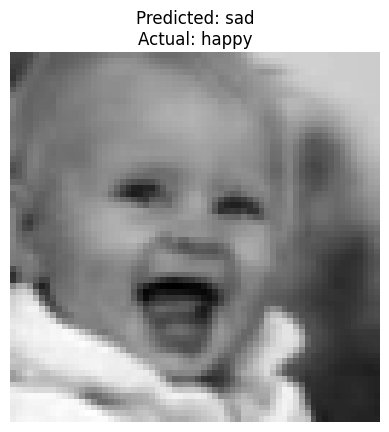

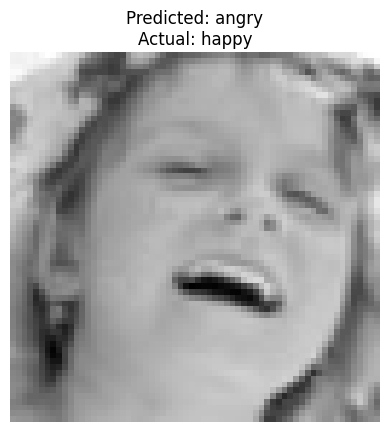

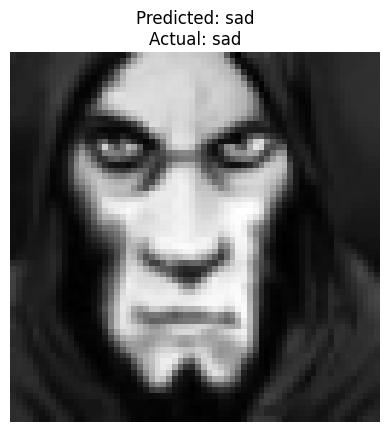

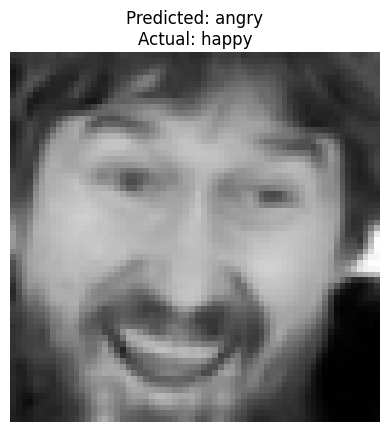

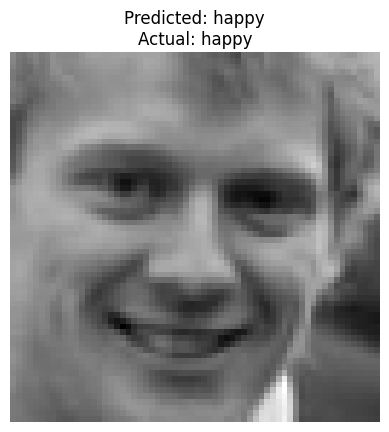

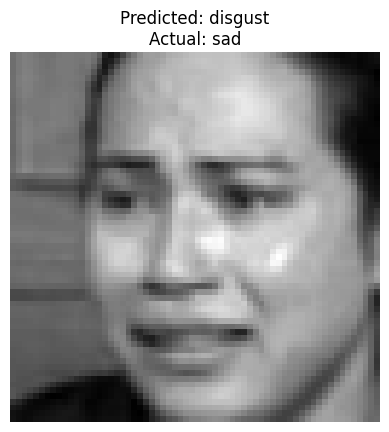

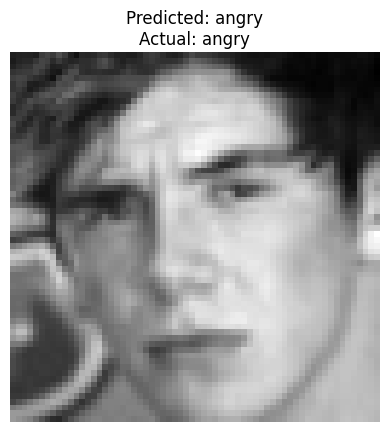

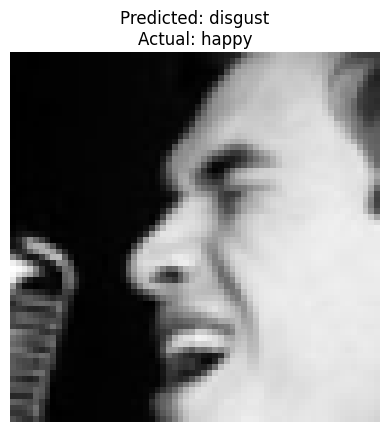

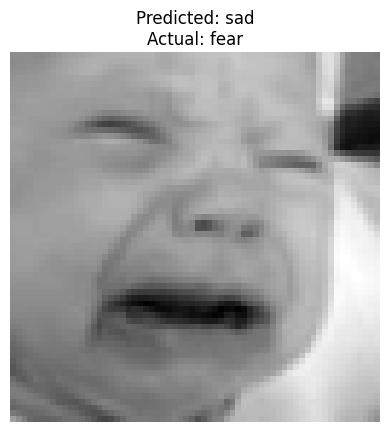

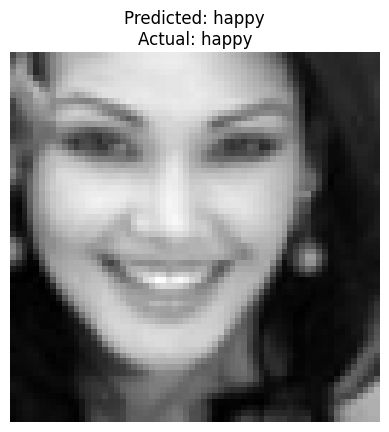

In [ ]:
import random
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Take 5 random images from the validation dataset
random_indices = random.sample(range(len(val_dataset)), 10)
random_images = [val_dataset[i][0] for i in random_indices]
random_labels = [val_dataset[i][1] for i in random_indices]

# Predict emotions for the random images
with torch.no_grad():
    for i, image in enumerate(random_images):
        image = image.unsqueeze(0)  # Add batch dimension
        image = image.to(device)     # Move image to GPU if available
        output = model(image)
        _, predicted_label = torch.max(output, 1)
        predicted_label = predicted_label.item()

        # Map predicted label to emotion
        emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
        predicted_emotion = emotions[predicted_label]

        # Get actual label (emotion)
        actual_label = emotions[random_labels[i]]

        # Display the image and labels
        plt.imshow(random_images[i].permute(1, 2, 0).numpy().squeeze(), cmap='gray')
        plt.title(f"Predicted: {predicted_emotion}\nActual: {actual_label}")
        plt.axis('off')
        plt.show()


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'emotion_classifier_model.pth')

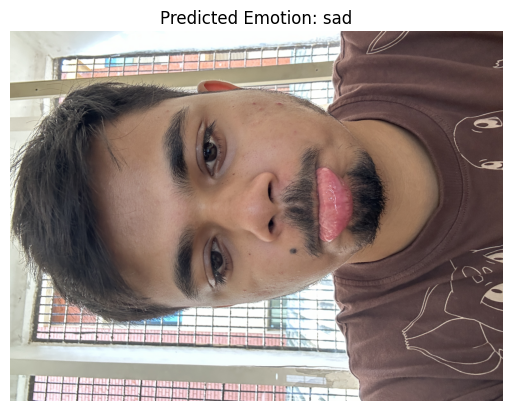

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load the saved model
loaded_model = EmotionClassifier().to(device)
loaded_model.load_state_dict(torch.load('emotion_classifier_model.pth'))
loaded_model.eval()

# Preprocess the new image
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

image_path = '/content/IMG_2136.JPG'
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0).to(device)

# Make predictions using the loaded model
with torch.no_grad():
    output = loaded_model(image_tensor)
    _, predicted = torch.max(output, 1)
    emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
    predicted_emotion = emotions[predicted.item()]

# Display the image
plt.imshow(image)
plt.title(f'Predicted Emotion: {predicted_emotion}')
plt.axis('off')
plt.show()


In [ ]:
loaded_model

EmotionClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)

In [ ]:
import cv2
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model = EmotionClassifier().to(device)
loaded_model.load_state_dict(torch.load('emotion_classifier_model.pth'))
loaded_model.eval()

# Function to detect emotion from a frame
def detect_emotion(frame):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    image_tensor = transform(frame).unsqueeze(0).to(device)

    with torch.no_grad():
        output = loaded_model(image_tensor)
        _, predicted = torch.max(output, 1)
        emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
        predicted_emotion = emotions[predicted.item()]

    return predicted_emotion

# Open the input video
input_video_path = 'demo.mov'
cap = cv2.VideoCapture(input_video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
output_video_path = '/content/output_video.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Process each frame of the video
frame_count = 0  # Initialize frame counter
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect emotion for the current frame
    emotion = detect_emotion(frame)

    # Display emotion in the frame
    cv2.putText(frame, f'Emotion: {emotion}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Write the frame into the output video
    out.write(frame)

    # Display the frame
    cv2.imshow('Frame', frame)

    # Print predicted emotion after every 10 frames
    frame_count += 1
    if frame_count % 10 == 0:
        print(f"Predicted emotion after {frame_count} frames: {emotion}")

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release video capture and writer
cap.release()
out.release()
cv2.destroyAllWindows()


TypeError: Unexpected type <class 'numpy.ndarray'>

In [ ]:
import cv2

# Path to the output video file
output_video_path = "sreya.MOV"

# Open the output video file
cap = cv2.VideoCapture(output_video_path)

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error: Failed to open the video file.")
else:
    # Loop through the video frames and play the video
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            # Display the current frame
            cv2.imshow('Output Video', frame)
            # Press 'q' to exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break

    # Release the video capture object and close all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()


Error: Failed to open the video file.


In [ ]:
model

EmotionClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)

In [ ]:
# importing libraries
import cv2
import numpy as np

# Create a VideoCapture object and read from input file
cap = cv2.VideoCapture('/content/sreya.MOV')

# Check if camera opened successfully
if (cap.isOpened()== False):
	print("Error opening video file")

# Read until video is completed
while(cap.isOpened()):

# Capture frame-by-frame
	ret, frame = cap.read()
	if ret == True:
	# Display the resulting frame
		cv2.imshow('Frame', frame)

	# Press Q on keyboard to exit
		if cv2.waitKey(25) & 0xFF == ord('q'):
			break

# Break the loop
	else:
		break

# When everything done, release
# the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()


Error opening video file


In [ ]:
import os

file_path = '/content/sreya.MOV'
if os.path.isfile(file_path):
    print("File exists and is accessible.")
else:
    print("File does not exist or is not accessible.")


File exists and is accessible.


In [ ]:
# importing libraries
import cv2
import numpy as np

# Create a VideoCapture object and read from input file
cap = cv2.VideoCapture('demo.mov')

# Check if camera opened successfully
if (cap.isOpened()== False):
	print("Error opening video file")

# Read until video is completed
while(cap.isOpened()):

# Capture frame-by-frame
	ret, frame = cap.read()
	if ret == True:
	# Display the resulting frame
		cv2.imshow('Frame', frame)

	# Press Q on keyboard to exit
		if cv2.waitKey(25) & 0xFF == ord('q'):
			break

# Break the loop
	else:
		break

# When everything done, release
# the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()


DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow
